# Image reconstruction in X-ray tomography

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse.linalg import LinearOperator, bicg
from scipy.sparse import diags
from scipy.linalg import pinv
from time import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from math import *
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize

**WARNING** : the ``plotly`` figures may not be displayed on a jupyter notebook environment: in this case, you can either rerun the code, or you can use a code editor (e.g. VS code).

In [2]:
H = loadmat('./data/H.mat')['H']
x = loadmat('./data/x.mat')['x']
w = np.random.randn(180*90).reshape(180*90, 1)
y = H@x + w

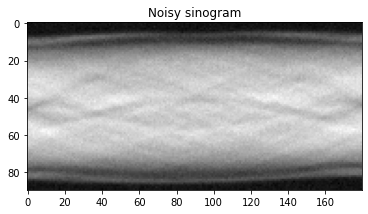

In [3]:
y_2D = y.reshape((90, 180), order='F')
plt.imshow(y_2D, cmap='gray')
plt.title('Noisy sinogram')
plt.show()

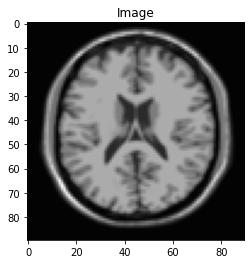

In [4]:
x_2D = x.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(x_2D, cmap='gray')
plt.show()

# Optimization problem

We focus on the following penalized least-squares criterion

$$(\forall x \in \mathbb R^N)\hspace{1cm}f(x) = \dfrac12||Hx - y||^2 + \lambda r(x)$$

where $r$ is a regularization function defined by

$$(\forall x \in \mathbb R^N)\hspace{1cm}r(x) = \sum_{n=1}^{2N} \psi([Gx]^{(n)})$$

where $G \in \mathbb R^{2N\times N}$ is a sparse matrix, and $\psi$ is a potention function defined as

$$(\forall u \in \mathbb R)\hspace{1cm}\psi(u) = \sqrt{1+u^2/\delta^2}$$

with some parameter $\delta > 0$.

We set $(\lambda, \delta) = (0.13, 0.02)$.

In [5]:
G = loadmat('./data/G.mat')['G']
lamb = 0.13
delta = 0.02

def psi(u, delta):
    return np.sqrt(1+(u/delta)**2)

def f(x, lamb, delta):
    return .5*np.square(H@x-y).sum() + lamb*psi(G@x, delta).sum()

For some point $x\in\mathbb R^N$, we have

$$\nabla f(x) = H^T(Hx - y) + \lambda \nabla r(x)$$

where 

$$\nabla r(x) = \sum_{n=1}^{2N} \psi'([Gx]^{(n)})\cdot G^T e_n$$

with $e_n$ being the $n^{th}$ vector of the canonical basis of $\mathbb R^N$. Therefore

$$\nabla f(x) = H^T(Hx - y) + \lambda G^T\left(\psi'([Gx]^{(n)})\right)_{1\le n \le 2N}$$

In addition,

$$(\forall u \in \mathbb R)\hspace{1cm}\psi'(u) = \dfrac{u}{\delta^2\sqrt{1+u^2/\delta^2}}$$


In [9]:
def grad_psi(u, delta): 
    return u/(delta**2 * np.sqrt(1+u**2/delta**2))

def grad_f(x, lamb, delta):
    return H.T@(H@x - y) + lamb*G.T@grad_psi(G@x, delta)

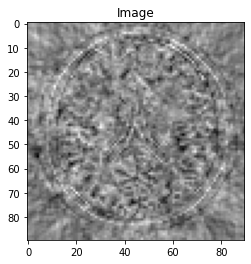

In [10]:
fx_2D = grad_f(x, lamb, delta).reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(fx_2D, cmap='gray')
plt.show()

Let us compute the Lipschitz-constant $L$ of $\nabla f$. But first, we need to compute the Lipschitz-constant of $\psi'$. For $u_1$, $u_2 \in \mathbb R$, we have

$$
\begin{align}
    ||\psi'(u_1) - \psi'(u_2)|| &= \left|\left|\dfrac{1}{\delta^2}\left(\dfrac{u_1}{\sqrt{1+u_1^2/\delta^2}} - \dfrac{u_2}{\sqrt{1 + u_2^2/\delta^2}}\right)\right|\right| \\
                                &\le \dfrac{1}{\delta^2}||u_1 - u_2||
\end{align}
$$

The inequality comes from the fact that the denominator is always greater than one, so we can upper bound the term on the right by $||u_1 - u_2||$. Then, for $x_1$, $x_2 \in \mathbb R^N$, we have

$$
\begin{align}
    ||\nabla f(x_1) - \nabla f(x_2)|| &= ||H^T(Hx_1 - y) + \lambda G^T\left(\psi'([Gx_1]^{(n)})\right)_{1\le n \le 2N} - H^T(Hx_2 - y) - \lambda G^T\left(\psi'([Gx_2]^{(n)})\right)_{1\le n \le 2N}||\\
         &= ||H^TH(x_1 - x_2) + \lambda G^T\left(\psi'([Gx_1]^{(n)}) - \psi'([Gx_2]^{(n)})\right)_{1\le n \le 2N}||\\
         &\le ||H||^2||x_1 - x_2|| + \dfrac{\lambda ||G||^2}{\delta^2}||x_1 - x_2||
\end{align}
$$

Therefore, $L = ||H||^2 + \dfrac{\lambda ||G||^2}{\delta^2}$.

In [11]:
uH, sH, vTH = svds(H, k=1, which='LM')
uG, sG, vTG = svds(G, k=1, which='LM')
L = max(sH)**2 + lamb/(delta**2)*max(sG)**2
print(f'L = {L}')

L = 18092.773276864787


# Optimization algorithms

## Gradient descent algorithm

In [13]:
def gradient_descent(max_iter=10000, lamb=lamb, delta=delta):
    x = [np.zeros((90*90,1))]
    res_f = [f(x[-1], lamb, delta)]
    n_iter = [0]
    criterion = False
    start_time = time()
    dt = [0]
    while not(criterion):
        df = grad_f(x[-1], lamb, delta)
        x.append(x[-1] - 1/L * df)
        res_f.append(f(x[-1], lamb, delta))
        dt.append(time() - start_time)
        norm_grad = np.linalg.norm(df)
        criterion = (norm_grad <= 90*1e-4)or(n_iter[-1] > max_iter)
        n_iter.append(n_iter[-1] + 1)
        if n_iter[-1] % 1000 == 0:
            checkpoint = time()
            print(f"Number of iterations: {n_iter[-1]}")
            print(f"Norm of the gradient: {norm_grad}")
            print(f"Elapsed time        : {checkpoint-start_time}")
    return x[-1], res_f, n_iter, dt

xGD, fGD, nGD, tGD = gradient_descent()

Number of iterations: 1000
Norm of the gradient: 5.872013461256158
Elapsed time        : 23.06412386894226
Number of iterations: 2000
Norm of the gradient: 0.583756673003762
Elapsed time        : 45.24391031265259
Number of iterations: 3000
Norm of the gradient: 0.1019345570788939
Elapsed time        : 67.34686756134033
Number of iterations: 4000
Norm of the gradient: 0.0224917730493125
Elapsed time        : 89.92659449577332


In [14]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nGD, y=fGD, 
      mode= 'lines+markers',
      name='$f$',
      line_color="firebrick"
))
fig1.update_layout(xaxis=dict(
                        title='Number of iterations', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over the number of iterations",
                  )
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tGD, y=fGD, 
      mode= 'lines+markers',
      name='$f$',
      line_color="royalblue"
))
fig2.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig2.show()

In [18]:
def SNR(xhat):
    return 10*log(np.square(x).sum()/np.square(x - xhat).sum(), 10)

In [19]:
sGD = SNR(xGD)

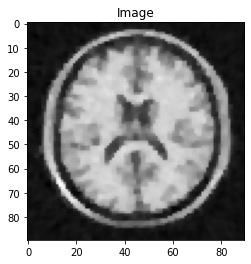

SNR = 18.967906437311882


In [20]:
xGD_2D = xGD.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(xGD_2D, cmap='gray')
plt.show()
print(f"SNR = {sGD}")

## MM quadratic algorithm

We want to build a quadratic majorant $h$ of $f$. Let us write the second order Taylor expansion of $f$ 

$$
(\forall x,x_0 \in \mathbb R^N)\hspace{1cm}h(x,x_0) = f(x_0) + \nabla f(x_0)^T(x-x_0) + \dfrac12 (x-x_0)^TA(x_0)(x-x_0)
$$

where $A(x_0)$ is the curvature of $h$ at $x_0$.

First, we need to find a majoration of $\psi$. We have

(i)   $\psi$ differentiable on $]0,+\infty[$,<br>
(ii)  For $u > 0$, $\psi'(\sqrt u) = \dfrac{1}{2\delta^2\sqrt{1+\dfrac{u}{\delta^2}}}$ is a decreasing function, therefore $\psi(\sqrt .)$ is concave,<br>
(iii) For $u \ge 0$, $\psi'(u) = \dfrac{u}{\delta^2\sqrt{1 + \dfrac{u^2}{\delta^2}}} \ge 0$,<br>
(iv)  For $u > 0$, set $\omega(u) := \dfrac{\psi'(u)}{u} = \dfrac{1}{\delta^2\sqrt{1+\dfrac{u^2}{\delta^2}}} \to_{u \to 0^+} \dfrac{1}{\delta^2} \in \mathbb R$. Also, note that $\psi(|u|) = \psi(u)$.

Then,

$$
(\forall u,v \in \mathbb R)\hspace{1cm} \psi(v) \le \psi(u) + \psi'(u)(v-u) + \dfrac12 \omega(u)(v-u)^2
$$

Setting $u = [Gx_0]^{(n)}$ and $v = [Gx]^{(n)}$, we deduce that

$$
\psi([Gx]^{(n)}) \le \psi([Gx_0]^{(n)}) + \psi'([Gx_0]^{(n)})[G(x-x_0)]^{(n)} + \dfrac12 w([Gx_0]^{(n)})\left([G(x-x_0)]^{(n)}\right)^2
$$

Finally, passing to the sum gives a majoration for $r$ :

$$
\begin{align*}
    r(x) &\le r(x_0) + \sum_{n=1}^{2N} \psi'([Gx_0]^{(n)})[G(x-x_0)]^{(n)} + \sum_{n=1}^{2N} \dfrac12 w([Gx_0]^{(n)})\left([G(x-x_0)]^{(n)}\right)^2 \\
         &\le r(x_0) + \underbrace{\left(\psi'([Gx_0]^{(n)})\right)_{1\le n \le 2N}^T}_{=\nabla r(x_0)^T} G(x-x_0) + \dfrac12 (x-x_0)^T \underbrace{G^T\mathbf{diag}(w([Gx_0]^{(n)})G}_{A_r(x_0)}(x-x_0)
\end{align*}
$$

Now consider $g : x \in \mathbb R \mapsto \dfrac12 ||Hx-y||^2$, we have $\nabla g(x) = H^T(Hx-y)$ and $\nabla^2 g(x) = H^TH$. We can set $A_g(x_0) = H^TH$ and by linear combination of the majorant matrices, we get for all $x_0 \in \mathbb R$

$$
\begin{align*}
    A(x_0) &= A_g(x_0) + \lambda A_r(x_0)\\
           &= H^TH + \lambda G^T\mathbf{diag}\left(w\left([Gx_0]^{(n)}\right)\right)G
\end{align*}
$$

We can now implement the following MM quadratic algorithm

$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        x_0 \in \mathbb R^N  \\
        x_{n+1} = x_n - A(x_n)^{-1}\nabla f(x_n)
    \end{array}
\right.$$

In [21]:
def w(u, delta):
    return 1/(delta**2 * np.sqrt(1+(u/delta)**2))

def b(x, delta):
    diag = np.squeeze(w(G@x, delta))
    return diags(diag).tocsc()

In [23]:
def mm_quadratic(max_iter=10000, lamb=lamb, delta=delta):
    x = [np.zeros((8100, 1))]
    res_f = [f(x[-1], lamb, delta)]
    n_iter = [0]
    criterion = False
    start_time = time()
    dt = [0]
    while not(criterion):
        def A(v):
            return H.T@(H@v) + lamb*G.T@b(x[-1], delta)@(G@v)
        matA = LinearOperator((8100, 8100), matvec=A, rmatvec=A)
        df = grad_f(x[-1], lamb, delta)
        x.append(x[-1] - bicg(matA, df)[0].reshape(8100, 1))
        res_f.append(f(x[-1], lamb, delta))
        dt.append(time() - start_time)
        norm_grad = np.linalg.norm(df)
        criterion = (norm_grad <= 90*1e-4)or(n_iter[-1] > max_iter)
        n_iter.append(n_iter[-1] + 1)
        if n_iter[-1] % 500 == 0:
            checkpoint = time()
            print(f"Number of iterations: {n_iter[-1]}")
            print(f"Norm of the gradient: {norm_grad}")
            print(f"Elapsed time        : {checkpoint-start_time}")
    return x[-1], res_f, n_iter, dt

xMM, fMM, nMM, tMM = mm_quadratic()
sMM = SNR(xMM)

In [24]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nMM, y=fMM, 
      mode= 'lines+markers',
      name='$f$',
      line_color="firebrick"
))
fig1.update_layout(xaxis=dict(
                        title='Number of iterations', 
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over the number of iterations",
                  )
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tMM, y=fMM, 
      mode= 'lines+markers',
      name='$f$',
      line_color="royalblue"
))
fig2.update_layout(xaxis=dict(
                        title='$t$', 
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig2.show()

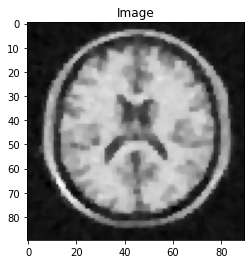

SNR = 18.96788765112802


In [26]:
xMM_2D = xMM.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(xMM_2D, cmap='gray')
plt.show()
print(f"SNR = {sMM}")

## 3MG algorithm

We now want to accelerate the previous algorithm by using a subspace strategy : one can do this with the 3MG algorithm.

First, define the directions

$$
(\forall k \in \mathbb N)\hspace{1cm} D_k = [-\nabla f(x_k) ~ | ~ x_k - x_{k-1} ]
$$

with the convention $D_0 = -\nabla f(x_0)$. Hence we get 

$$
(\forall k \in \mathbb N)\hspace{1cm} x_{k+1} = x_k + D_ku_k
$$

where

$$
(\forall k \in \mathbb N)\hspace{1cm} u_k = -(D_k^TA(x_k)D_k)^\dagger(D_k^T\nabla f(x_k))
$$

In [30]:
def mm_mg(max_iter=10000, lamb=lamb, delta=delta):
    x = [np.zeros((8100, 1))]
    res_f = [f(x[-1], lamb, delta)]
    d = -grad_f(x[-1], lamb, delta)
    n_iter = [0]
    criterion = False
    start_time = time()
    dt = [0]
    while not(criterion):
        mat1 = H@d
        mat2 = G@d
        df = grad_f(x[-1], lamb, delta) 
        u = -pinv(mat1.T@mat1 + lamb*mat2.T@b(x[-1], delta)@mat2)@(d.T@df)
        x.append(x[-1] + d@u)
        res_f.append(f(x[-1], lamb, delta))
        dt.append(time() - start_time)
        d = np.hstack([-grad_f(x[-1], lamb, delta), x[-1] - x[-2]])
        norm_grad = np.linalg.norm(df)
        criterion = (norm_grad <= 90*1e-4)or(n_iter[-1] > max_iter)
        n_iter.append(n_iter[-1] + 1)
        if n_iter[-1] % 500 == 0:
            checkpoint = time()
            print(f"Number of iterations: {n_iter[-1]}")
            print(f"Norm of the gradient: {norm_grad}")
            print(f"Elapsed time        : {checkpoint-start_time}")
    return x[-1], res_f, n_iter, dt

xMG, fMG, nMG, tMG = mm_mg()
sMG = SNR(xMG)

In [31]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nMG, y=fMG, 
      mode= 'lines+markers',
      name='$f$',
      line_color="firebrick"
))
fig1.update_layout(xaxis=dict(
                        title='Number of iterations', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over the number of iterations",
                  )
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tMG, y=fMG, 
      mode= 'lines+markers',
      name='$f$',
      line_color="royalblue"
))
fig2.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig2.show()

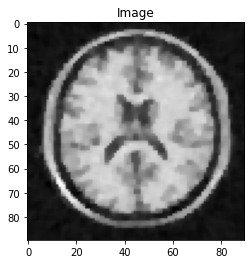

SNR = 18.967866887445368


In [32]:
xMG_2D = xMG.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(xMG_2D, cmap='gray')
plt.show()
print(f"SNR = {sMG}")

## Block-coordinate MM quadratic algorithm

Another acceleration strategy consists in applying a block alternation technique.
The vector x is divided into $J \ge 1$ blocks, with size $1\le N_j \le N$. At each iteration $k\in \mathbb N$, a block index $j \subset \{1,...,J\}$ is chosen, and the corresponding components of $x$, denoted $x^{(j)}$, are updated, according to a MM quadratic rule. Here, we will
assume that the blocks are selected in a cyclic manner, that is,

$$
(\forall k \in \mathbb N)\hspace{1cm} j = \mathbf{mod}(k-1, J) + 1
$$

For a given block index $j$, the corresponding pixel indexes are updated in the image

$$
n \in \mathbb J_j = \{N_j(j-1) + 1,..., jN_j\}
$$

We can now implement the following block-coordinate MM algorithm:

$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        x_0 \in \mathbb R^N  \\
        x_{n+1}[\mathbb J_j] = x_n[\mathbb J_j] - A_j(x_n)^{-1}\nabla f(x_n)[\mathbb J_j]
    \end{array}
\right.$$

In [33]:
def Aj(x, j, Nj, lamb, delta):
    H_new = H[:, Nj*(j-1):j*Nj]
    G_new = G[:, Nj*(j-1):j*Nj]
    return H_new.T@H_new + lamb*G_new.T@b(x, delta)@G_new

In [35]:
def bcmm(max_iter=10000, K=9, lamb=lamb, delta=delta):
    x = np.zeros((8100, 1))
    res_f = [f(x, lamb, delta)]
    Nj = 8100//K
    n_iter = [0]
    criterion = False
    start_time = time()
    dt = [0]
    while not(criterion):
        j = n_iter[-1]%K + 1
        df = grad_f(x, lamb, delta)
        matA = Aj(x, j, Nj, lamb, delta)
        x[Nj*(j-1):j*Nj] -= bicg(matA, df[Nj*(j-1):j*Nj])[0].reshape(-1, 1)
        res_f.append(f(x, lamb, delta))
        dt.append(time() - start_time)
        norm_grad = np.linalg.norm(df)
        criterion = (norm_grad <= 90*1e-4)or(n_iter[-1] > max_iter)
        n_iter.append(n_iter[-1] + 1)
        if n_iter[-1] % 500 == 0:
            checkpoint = time()
            print(f"Number of iterations: {n_iter[-1]}")
            print(f"Norm of the gradient: {norm_grad}")
            print(f"Elapsed time        : {checkpoint-start_time}")
    return x, res_f, n_iter, dt

xBC, fBC, nBC, tBC = bcmm()
sBC = SNR(xBC)

Number of iterations: 500
Norm of the gradient: 0.03758573745886897
Elapsed time        : 99.23166012763977


In [36]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nBC, y=fBC, 
      mode= 'lines+markers',
      name='$f$',
      line_color="firebrick"
))
fig1.update_layout(xaxis=dict(
                        title='Number of iterations', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over the number of iterations",
                  )
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tBC, y=fBC, 
      mode= 'lines+markers',
      name='$f$',
      line_color="royalblue"
))
fig2.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig2.show()

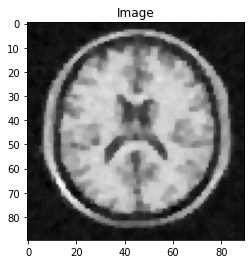

SNR = 18.96788453272156


In [37]:
xBC_2D = xBC.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(xBC_2D, cmap='gray')
plt.show()
print(f"SNR = {sBC}")

## Parallel MM quadratic algorithm

Suppose $g$ is a convex function, and $w$ is a vector such that $\displaystyle \sum_{p=1}^P w^{(p)} = 1$. Then, the Jensen inequality gives

$$
g\left(\sum_{p=1}^P w^{(p)}\dfrac{c^{(p)}x^{(p)}}{w^{(p)}}\right) \le \sum_{p=1}^P w^{(p)}g\left(\dfrac{c^{(p)}x^{(p)}}{w^{(p)}}\right)
$$

Take $g: u\mapsto u^2$, then $g$ is convex. For some $m \in \{1,...,M\}$, set $c^{(p)} = \left|H^{(m,p)}\right|$, then the above expression becomes, for all $x \in\mathbb R^N, m \in \{1,...,M\}$

$$
g\left([Hx]^{m}\right) \le \sum_{i=1}^N \dfrac{\left|H^{(m,i)}\right|^2}{w_i} x^2_i
$$

This yields

$$
\begin{align*}
    x^TH^THx &= \sum_{m=1}^M g\left([Hx]^{(m)}\right)\\
             &\le \sum_{m=1}^M \sum_{i=1}^N \dfrac{\left|H^{(m,i)}\right|^2}{w_i} x^2_i\\
             &= \sum_{m=1}^M \sum_{i=1}^N x^2_i \left|H^{(m,i)}\right| \sum_{j=1}^N\left|H^{(m,j)}\right|\\
             &= \sum_{m=1}^M \sum_{i=1}^N x^2_i \mathcal H_i^{(m)}\\
             &= \sum_{i=1}^N x^2_i \sum_{m=1}^M \mathcal H_i^{(m)}\\
             &= \sum_{i=1}^N x_i^2 \mathcal H_i^T\mathbf 1\\
\end{align*}
$$

Similarly, we can consider the convex functions $g_n: u \mapsto w([Gx]^{(n)})u^2$. For some $n \in \{1,...,N\}$, set $c_i = \left|G^{(n,i)}\right|$, then

$$
\begin{align*}
    g_n\left([Gx]^{(n)}\right) \le w([Gx]^{(n)})\sum_{i=1}^N \dfrac{\left|G^{(n,i)}\right|^2}{w_i}x_i^2
\end{align*}
$$

This yields

$$
\begin{align*}
    x^TG^TGx &= \sum_{n=1}^N g_n\left([Gx]^{(n)}\right) \\
             &\le \sum_{n=1}^N \sum_{i=1}^N \dfrac{\left|G^{(n,i)}\right|^2}{w_i}w([Gx]^{(n)})x_i^2\\
             &= \sum_{n=1}^N \sum_{i=1}^N x_i^2 \mathcal G_i^{(n)}w([Gx]^{(n)}) \\
\end{align*}
$$

Therefore

$$
\begin{align*}
    A(x) \preceq B(x) := \mathbf{diag}\left(\mathcal H_i^T\mathbf 1 + \lambda\mathcal G_i^T\left(w\left([Gx]^{(n)}\right)\right)_{1\le n\le 2N}\right)
\end{align*}
$$

In [42]:
def mm_parallel(max_iter=10000, lamb=lamb, delta=delta):
    H_new = diags(np.squeeze(np.array(H.sum(1))))@H
    G_new = diags(np.squeeze(np.array(G.sum(1))))@G
    H_new1 = H_new.T@np.ones(H_new.shape[0])
    x = [np.zeros((8100, 1))]
    res_f = [f(x[-1], lamb, delta)]
    n_iter = [0]
    criterion = False
    start_time = time()
    dt = [0]
    while not(criterion):
        matB_inv = diags(1/(H_new1 + lamb*G_new.T@w(G@np.squeeze(x[-1]), delta)))
        df = grad_f(x[-1], lamb, delta)
        x.append(x[-1] - matB_inv*df)
        res_f.append(f(x[-1], lamb, delta))
        dt.append(time() - start_time)
        norm_grad = np.linalg.norm(df)
        criterion = (norm_grad <= 90*1e-4)or(n_iter[-1] > max_iter)
        n_iter.append(n_iter[-1] + 1)
        if n_iter[-1] % 500 == 0:
            checkpoint = time()
            print(f"Number of iterations: {n_iter[-1]}")
            print(f"Norm of the gradient: {norm_grad}")
            print(f"Elapsed time        : {checkpoint-start_time}")
    return x[-1], res_f, n_iter, dt

xMMP, fMMP, nMMP, tMMP = mm_parallel()
sMMP = SNR(xMMP)

Number of iterations: 500
Norm of the gradient: 22.390450811237145
Elapsed time        : 12.263390064239502
Number of iterations: 1000
Norm of the gradient: 3.8343634506241564
Elapsed time        : 24.862412691116333
Number of iterations: 1500
Norm of the gradient: 0.9873036278004607
Elapsed time        : 37.22353553771973
Number of iterations: 2000
Norm of the gradient: 0.31412884237585087
Elapsed time        : 50.00979924201965
Number of iterations: 2500
Norm of the gradient: 0.11333261260406233
Elapsed time        : 62.8639931678772
Number of iterations: 3000
Norm of the gradient: 0.044217677703897715
Elapsed time        : 75.46203684806824
Number of iterations: 3500
Norm of the gradient: 0.01816597764882371
Elapsed time        : 88.05856347084045


In [43]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nMMP, y=fMMP, 
      mode= 'lines+markers',
      name='$f$',
      line_color="firebrick"
))
fig1.update_layout(xaxis=dict(
                        title='Number of iterations', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over the number of iterations",
                  )
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tMMP, y=fMMP, 
      mode= 'lines+markers',
      name='$f$',
      line_color="royalblue"
))
fig2.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig2.show()

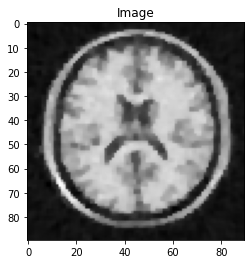

SNR = 18.967908811127447


In [44]:
xMMP_2D = xMMP.reshape(90, 90, order='F')
plt.title('Image')
plt.imshow(xMMP_2D, cmap='gray')
plt.show()
print(f"SNR = {sMMP}")

## Comparison of the methods

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tGD, y=fGD, 
      mode= 'lines+markers',
      name=f'Gradient Descent (SNR={round(sGD,4)})',
))
fig.add_trace(go.Scatter(x=tMM, y=fMM, 
      mode= 'lines+markers',
      name=f'MM Quadratic (SNR={round(sMM,4)})',
))
fig.add_trace(go.Scatter(x=tMG, y=fMG, 
      mode= 'lines+markers',
      name=f'MM Memory Gradient (SNR={round(sMG,4)})',
))
fig.add_trace(go.Scatter(x=tBC, y=fBC, 
      mode= 'lines+markers',
      name=f'Block-coordinate MM Quadratic (SNR={round(sBC,4)})',
))
fig.add_trace(go.Scatter(x=tMMP, y=fMMP, 
      mode= 'lines+markers',
      name=f'Parallel MM (SNR={round(sMMP,4)})',
))
fig.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig.show()

According to this graph, the fastest algorithm is the **MM Memory gradient**.

### Grid search

In [34]:
def finetuning(gridlength):
    lambdas = np.linspace(1e-3, 0.2, gridlength)
    deltas = np.linspace(1e-3, 2, gridlength)
    SNRs = {}
    for lamb in lambdas:
        for delta in deltas:
            xhat,_,_,_ = mm_mg(lamb=lamb, delta=delta)
            SNRs[lamb, delta] = SNR(xhat)
    return min(SNRs.items(), key=lambda x:x[1])

In [53]:
#finetuning(10):
#(0.1416428789186059, 0.025850928251438057)

In [54]:
xMG_gs, fMG_gs, nMG_gs, tMG_gs = mm_mg(lamb=.1416428789186059,delta=.025850928251438057)
sMG_gs = SNR(xMG_gs)

### Bayesian optimization

In [49]:
search_space = [Real(0.001, 0.2, prior='uniform', name='lamb'), Real(0.001, 2, prior='uniform', name='delta')]

@use_named_args(search_space)
def evaluate_model(**params):
    print(params)
    xhat,_,_,_ = mm_mg(**params, max_iter=5000)
    s = SNR(xhat)
    print(s)
    return -s

result = gp_minimize(evaluate_model, search_space, random_state=0)

{'lamb': 0.11897607902677867, 'delta': 1.688687231413454}
Number of iterations: 500
Norm of the gradient: 3.7396135543225864
Elapsed time        : 24.058947324752808
Number of iterations: 1000
Norm of the gradient: 0.7765166345908482
Elapsed time        : 47.953301668167114
Number of iterations: 1500
Norm of the gradient: 0.0929622819479791
Elapsed time        : 72.23798847198486
Number of iterations: 2000
Norm of the gradient: 0.017105052979692902
Elapsed time        : 96.54660940170288
-1.1042424256793524
{'lamb': 0.17173117790692866, 'delta': 1.694656225829467}
Number of iterations: 500
Norm of the gradient: 2.959388795230437
Elapsed time        : 23.86679196357727
Number of iterations: 1000
Norm of the gradient: 0.36349046795052653
Elapsed time        : 47.911967515945435
Number of iterations: 1500
Norm of the gradient: 0.03139492850331884
Elapsed time        : 72.0367021560669
0.28917607437867465
{'lamb': 0.12508917566040853, 'delta': 0.7693790328781073}
Number of iterations: 500


/home/campagne/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



13.565872884471265


/home/campagne/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



{'lamb': 0.001, 'delta': 0.001}
13.565872884471265
{'lamb': 0.08127936426617074, 'delta': 0.001}
Number of iterations: 500
Norm of the gradient: 1.7080520475708472
Elapsed time        : 24.126410245895386
Number of iterations: 1000
Norm of the gradient: 0.035345307191487624
Elapsed time        : 48.26285219192505
12.024270683102111
{'lamb': 0.001, 'delta': 0.06072329850645912}
Number of iterations: 500
Norm of the gradient: 22.588351644474365
Elapsed time        : 25.275250673294067
Number of iterations: 1000
Norm of the gradient: 6.356220129533256
Elapsed time        : 49.51845932006836
Number of iterations: 1500
Norm of the gradient: 2.206741388573705
Elapsed time        : 73.77016234397888
Number of iterations: 2000
Norm of the gradient: 0.9201367597142434
Elapsed time        : 98.24611568450928
Number of iterations: 2500
Norm of the gradient: 0.3859649848248456
Elapsed time        : 122.4600670337677
Number of iterations: 3000
Norm of the gradient: 0.15554801235946897
Elapsed time 

{'lamb': 0.2, 'delta': 0.062009659040187244}
17.9949525811583
{'lamb': 0.19622149112124893, 'delta': 0.03726100576704443}
19.1282004007186
{'lamb': 0.19531460204872678, 'delta': 0.0368212605134557}
19.132148916615662
{'lamb': 0.001, 'delta': 0.2446259223578148}
Number of iterations: 500
Norm of the gradient: 34.10736411753636
Elapsed time        : 23.844027280807495
Number of iterations: 1000
Norm of the gradient: 16.736645502359405
Elapsed time        : 47.75990414619446
Number of iterations: 1500
Norm of the gradient: 8.377703113665998
Elapsed time        : 71.67265796661377
Number of iterations: 2000
Norm of the gradient: 6.179244213450407
Elapsed time        : 97.46190047264099
Number of iterations: 2500
Norm of the gradient: 4.551243065962748
Elapsed time        : 122.9588234424591
Number of iterations: 3000
Norm of the gradient: 2.856840876107649
Elapsed time        : 147.03731751441956
Number of iterations: 3500
Norm of the gradient: 2.059674277358619
Elapsed time        : 171.0

Number of iterations: 500
Norm of the gradient: 1.7505374561736848
Elapsed time        : 24.447187423706055
Number of iterations: 1000
Norm of the gradient: 0.057142990220997864
Elapsed time        : 48.69239330291748
2.9818184939999237
{'lamb': 0.2, 'delta': 1.8237047789151446}
Number of iterations: 500
Norm of the gradient: 2.742908715858499
Elapsed time        : 25.416269540786743
Number of iterations: 1000
Norm of the gradient: 0.26022837910157803
Elapsed time        : 49.29362392425537
Number of iterations: 1500
Norm of the gradient: 0.024741515104058573
Elapsed time        : 73.19673919677734
0.3819600316648661
{'lamb': 0.13718884836350137, 'delta': 0.11984350157092735}
13.319495418494167
{'lamb': 0.2, 'delta': 0.19526624664833633}
12.307338134979787
{'lamb': 0.19638781457889717, 'delta': 0.03251464426099048}
19.171355698878333
{'lamb': 0.001, 'delta': 2.0}
Number of iterations: 500
Norm of the gradient: 23.52843714771206
Elapsed time        : 25.05372190475464
Number of iteratio

In [52]:
#print(f"Best SNR   : {-result.fun}")
#print(f"Best lambda: {result.x[0]}")
#print(f"Best delta : {result.x[1]}")
#Best SNR   : 19.17818909449403
#Best lambda: 0.2
#Best delta : 0.033732948506737755

In [55]:
xMG_bo, fMG_bo, nMG_bo, tMG_bo = mm_mg(lamb=0.2,delta=.033732948506737755)
sMG_bo = SNR(xMG_bo)

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tMG, y=fMG, 
      mode= 'lines+markers',
      name='MM Memory Gradient (no tuning)',
))
fig.add_trace(go.Scatter(x=tMG_gs, y=fMG_gs, 
      mode= 'lines+markers',
      name='MM Memory Gradient (gridsearch)',
))
fig.add_trace(go.Scatter(x=tMG_bo, y=fMG_bo, 
      mode= 'lines+markers',
      name='MM Memory Gradient (bayesian)',
))
fig.update_layout(xaxis=dict(
                        title='$t$', 
                        type='log'
                    ),
                   yaxis=dict(
                       title='$f$',
                       type='log', 
                       showexponent= 'all',
                       exponentformat= 'e'
                       ),
                   title="Evolution of f over time",
                  )
fig.show()

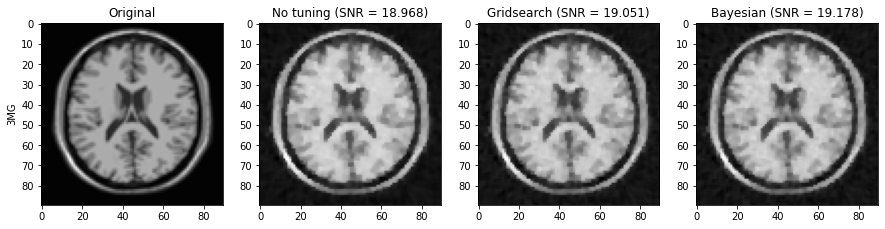

In [87]:
xMG_bo_2D = xMG_bo.reshape(90, 90, order='F')
xMG_gs_2D = xMG_gs.reshape(90, 90, order='F')

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(x_2D,      cmap='gray')
axes[1].imshow(xMG_2D,    cmap='gray')
axes[2].imshow(xMG_gs_2D, cmap='gray')
axes[3].imshow(xMG_bo_2D, cmap='gray')

plt.setp(axes[0], ylabel='3MG')
axes[0].set_title("Original")
axes[1].set_title(f"No tuning (SNR = {round(SNR(xMG),     3)})")
axes[2].set_title(f"Gridsearch (SNR = {round(SNR(xMG_gs), 3)})")
axes[3].set_title(f"Bayesian (SNR = {round(SNR(xMG_bo),   3)})")

plt.show()